# Suicide Rate Prediction Regression Model

The purpose of this notebook is to create a regression model to predict the suicide rate of a city in a certain year. 

The features used for this model are the disease rates from the previous year for that city, as well as the state where it is located and the suicide rate from the previous year.

---

Import libraries

In [29]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# DataPrep
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Tuning
from skopt import gp_minimize
# Feature Selection
from sklearn.feature_selection import RFE,SelectFromModel
# Models
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import pickle
import joblib

# Evaluation
from sklearn import metrics

# Plotting
import sys
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import geoplot
# import mapclassify
sys.path.append(os.path.abspath('..'))
%matplotlib inline

import time
import glob
import shap
root = "../../"

In [2]:
dict_uf_cod = {11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE',
29: 'BA', 31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP', 41: 'PR', 42: 'SC', 43: 'RS',
50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'}

# DataPrep
*You can skip this and load the csv directly after this section*

---

## DataPrep (models)

Getting a list of all diseases

In [ ]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")
suicide = pd.read_csv(root +'CSV/Suicide/suicide_rates_08_18.csv', index_col=0)

years = [str(x).zfill(2) for x in range(8,19)]
columns = ["RATE_" + year for year in years]
columns.append("MUNCOD")

disease_list = []

for file in all_files:
    file_name = file.split("/")[-1]
    disease = file_name.split(".csv")[0]
    disease_df = pd.read_csv(file, sep=',', index_col=0)
    if(set(disease_df.columns) == set(columns)):
        disease_list.append(disease)
print(len(disease_list), " diseases")

Creating dataframe by using only rows with **at least 80% values that are not NaN** 

In [ ]:
initial_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(len(years)-1):
    col_year_suicide = "RATE_" + years[i+1]
    col_year_prev = "RATE_" + years[i]
    year_df = suicide[[col_year_prev, col_year_suicide, "MUNCOD"]]
    year_df = year_df.rename(columns={col_year_suicide: "RATE"})
    year_df = year_df.rename(columns={col_year_prev: "PREVIOUS"})
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df = disease_df.rename(columns={col_year_disease: disease})

        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)  
    year_df = year_df.dropna(thresh=N)
    initial_df = pd.concat([initial_df, year_df])

initial_df.head()

Filling NaN values with zero and getting state code from MUNCOD column

In [ ]:
df = initial_df.copy()

# Fill NaN values with 0
df = df.fillna(0)

# Get MUNCOD from UF
df['UF'] = df['MUNCOD'] / 10000
df['UF'] = df['UF'].astype(int)
df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(df['UF'])
df = pd.concat([df, dummy], axis=1)
df = df.drop(['MUNCOD', 'UF'], axis=1)

# Removing outliers
df = df[(np.abs(stats.zscore(df["RATE"])) < 3)] 
df.head()

In [ ]:
df.to_csv("df_regression.csv")

## DataPrep (2018 predictions)

Getting training data (2008-2017)

In [ ]:
train_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-2):
    col_year_suicide = "RATE_" + years[i+1]
    col_year_prev = "RATE_" + years[i]
    year_df = suicide[[col_year_prev, col_year_suicide, "MUNCOD"]]
    year_df = year_df.rename(columns={col_year_suicide: "RATE"})
    year_df = year_df.rename(columns={col_year_prev: "PREVIOUS"})
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df = disease_df.rename(columns={col_year_disease: disease})

        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)  
    year_df = year_df.dropna(thresh=N)
    train_df = pd.concat([train_df, year_df])

train_df.head()

In [ ]:
# Fill NaN values with 0
train_df = train_df.fillna(0)

# Get MUNCOD from UF
train_df['UF'] = train_df['MUNCOD'] / 10000
train_df['UF'] = train_df['UF'].astype(int)
train_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(train_df['UF'])
train_df = pd.concat([train_df, dummy], axis=1)
train_df = train_df.drop(['MUNCOD', 'UF'], axis=1)

# Removing outliers
train_df = train_df[(np.abs(stats.zscore(train_df["RATE"])) < 3)] 

train_df.head()

In [ ]:
train_df.to_csv("train_data_regression.csv")

Getting testing data (2018)

In [ ]:
percentage_valid_values = 0.8
col_year_suicide = "RATE_18"
col_year_prev = "RATE_17"
test_df = suicide[[col_year_prev, col_year_suicide, "MUNCOD"]]
test_df = test_df.rename(columns={col_year_suicide: "RATE"})
test_df = test_df.rename(columns={col_year_prev: "PREVIOUS"})
for disease in disease_list:
    col_year_disease = "RATE_17"
    disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
    disease_df = disease_df[[col_year_disease, "MUNCOD"]]
    disease_df = disease_df.rename(columns={col_year_disease: disease})

    test_df = pd.merge(disease_df, test_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
N = int(test_df.shape[1]*percentage_valid_values)  
test_df = test_df.dropna(thresh=N)

test_df.head()

In [28]:
# Fill NaN values with 0
test_df = test_df.fillna(0)

# Get MUNCOD from UF
test_df['UF'] = test_df['MUNCOD'] / 10000
test_df['UF'] = test_df['UF'].astype(int)
test_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(test_df['UF'])
test_df = pd.concat([test_df, dummy], axis=1)
test_df = test_df.drop(['MUNCOD', 'UF'], axis=1)

# Removing outliers
test_df = test_df[(np.abs(stats.zscore(test_df["RATE"])) < 3)] 

In [29]:
test_df.to_csv("test_data_regression.csv")

In [27]:
test_df = pd.read_csv("test_data_regression.csv", index_col=0)

# Model

In [3]:
df = pd.read_csv("df_regression.csv",index_col=0)
train_df = pd.read_csv("train_data_regression.csv", index_col=0)
test_df = pd.read_csv("test_data_regression.csv", index_col=0)

Defining X and y

In [4]:
X = df.drop(columns=["RATE"])
y = df["RATE"]

X.shape

(9640, 341)

Defining some functions

In [5]:
def calcUpMetrics(y_pred,y_test,X_test):
    up_df = pd.DataFrame({"Pred": y_pred, "Real": y_test, "Previous": X_test["PREVIOUS"]})
    up_df["UP"] = up_df["Previous"] < up_df["Real"]
    up_df["UP_PRED"] = up_df["Previous"] < up_df["Pred"]
    up_df["UP"] = up_df["UP"].astype(int)
    up_df["UP_PRED"] = up_df["UP_PRED"].astype(int)
    print("Previsão de 0s:", up_df[up_df["UP_PRED"] == 0].shape)
    print("Previsão de 1s:", up_df[up_df["UP_PRED"] == 1].shape)
    print("Real 0s:", up_df[up_df["UP"] == 0].shape)
    print("Real 1s:", up_df[up_df["UP"] == 1].shape)
    print("Acc", metrics.accuracy_score(up_df["UP"], up_df["UP_PRED"]))
    print("recall_score", metrics.recall_score(up_df["UP"], up_df["UP_PRED"]))
    print("precision_score", metrics.precision_score(up_df["UP"], up_df["UP_PRED"]))
    print("f1_score", metrics.f1_score(up_df["UP"], up_df["UP_PRED"]))
    return metrics.recall_score(up_df["UP"], up_df["UP_PRED"])

In [6]:
def get_average_feat_importance(feature_importance_list):
    final_feat_df = pd.DataFrame()
    for i, feat_df in enumerate(feature_importance_list):
        feat_df = feat_df.rename(columns={"Importance": i})
        if final_feat_df.empty:
            final_feat_df = feat_df
        else:
            final_feat_df = pd.merge(final_feat_df, feat_df, on="Feature")
    final_feat_df["Avg_importance"] = final_feat_df.sum(axis=1)/(final_feat_df.shape[1] -1)
    final_feat_df = final_feat_df[["Feature", "Avg_importance"]]
    return final_feat_df

In [7]:
def cor_feature_selector(X,y,corr_min_value):
    cor_list = []
    for i in list(X.columns):
        cor = np.corrcoef(X[i], y)[0,1]
        cor_list.append([i, cor])
    cor_feature = [x[0] for x in cor_list if abs(x[1]) > corr_min_value]
    print(len(cor_feature), "selected features (correlation)")
    return cor_feature

In [8]:
def calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores=None):
    rmse_train = np.sqrt(metrics.mean_squared_error(y_pred_train,y_train))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_pred,y_test))
    rmse_baseline_train = np.sqrt(metrics.mean_squared_error(X_train["PREVIOUS"],y_train))
    rmse_baseline_test = np.sqrt(metrics.mean_squared_error(X_test["PREVIOUS"],y_test))
    print("\nMetrics Train:")
    up_down_train = calcUpMetrics(y_pred_train,y_train,X_train)
    print("\nMetrics Test:")
    up_down_test = calcUpMetrics(y_pred,y_test,X_test)
                                 
    print("\nRMSE Train:", rmse_train)
    print("RMSE Test:", rmse_test)
    print("RMSE Baseline Train:", rmse_baseline_train)
    print("RMSE Baseline Test:", rmse_baseline_test)
    print("Up/Down Recall Train:", up_down_train)
    print("Up/Down Recall Test:", up_down_test)
    if scores is not None:
        scores = scores.append({'rmse_train':rmse_train, 'rmse_test':rmse_test, "rmse_baseline_train": rmse_baseline_train, "rmse_baseline_test": rmse_baseline_test, "up_down_train": up_down_train, "up_down_test": up_down_test},ignore_index=True)
        return scores

In [9]:
num_feat = 50
corr_min_value = 0.05
all_models_scores = {}

## Random Forest

### No Scaling

In [10]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_leaf = params[2]
        max_features = params[3]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (5,1000), #n_estimators
        (3,30), #max_depth
        (2,200), #min_samples_leaf
        (0.25,1.00) #max_features
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=resultado_gp.x[0], 
                                  max_depth=resultado_gp.x[1],min_samples_leaf=resultado_gp.x[2],max_features=resultado_gp.x[3])
    regressor.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = regressor.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    print("\n")
    count += 1
print("=============== SUMMARY Random Forest ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["Random Forest"] = scores
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
print(final_feat_df.head(20))
end = time.time()

print("\nTotal run time:", end-start)

print("\n=============== SAVE Y_TEST_PRED ===============")
y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"], "y_test": y_test, "y_pred": y_pred})
y_test_pred.to_csv('y_test_pred_RandomForest.csv')

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3447, 5)
Previsão de 1s: (4265, 5)
Real 0s: (4263, 5)
Real 1s: (3449, 5)
Acc 0.8521784232365145
recall_score 0.953029863728617
precision_score 0.7706916764361078
f1_score 0.8522167487684729

Metrics Test:
Previsão de 0s: (785, 5)
Previsão de 1s: (1143, 5)
Real 0s: (1088, 5)
Real 1s: (840, 5)
Acc 0.658195020746888
recall_score 0.7880952380952381
precision_score 0.57917760279965
f1_score 0.6676752395360565

RMSE Train: 1.6189803214446532
RMSE Test: 3.6397193691679566
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.953029863728617
Up/Down Recall Test: 0.7880952380952381
# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian O

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3501, 5)
Previsão de 1s: (4211, 5)
Real 0s: (4295, 5)
Real 1s: (3417, 5)
Acc 0.8609958506224067
recall_score 0.9593210418495757
precision_score 0.7784374257895986
f1_score 0.859465128474043

Metrics Test:
Previsão de 0s: (778, 5)
Previsão de 1s: (1150, 5)
Real 0s: (1056, 5)
Real 1s: (872, 5)
Acc 0.691908713692946
recall_score 0.8188073394495413
precision_score 0.6208695652173913
f1_score 0.7062314540059348

RMSE Train: 1.5438020334809033
RMSE Test: 3.6286097487848075
RMSE Baseline Train: 4.926016728480818
RMSE Baseline Test: 5.022730507675877
Up/Down Recall Train: 0.9593210418495757
Up/Down Recall Test: 0.8188073394495413
# Get Feature Importance


=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3447, 5)
Previsão de

In [31]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)

with open('selected_cor_features', 'wb') as fp:
    pickle.dump(selected_cor_features, fp)
    
X_train = X_train[selected_cor_features]

def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=resultado_gp.x[0], 
                              max_depth=resultado_gp.x[1],min_samples_leaf=resultado_gp.x[2],max_features=resultado_gp.x[3])
regressor.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/random_forest_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

126 selected features (correlation)


### SHAP

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=1/5)

print("# Feature Selection: correlation")
selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
X_train = X_train[selected_cor_features]
X_test = X_test[selected_cor_features]

print("# Bayesian Optimization")
def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

print("# Fitting the model")
regressor = RandomForestRegressor(n_jobs=-1, random_state=42,n_estimators=resultado_gp.x[0], 
                              max_depth=resultado_gp.x[1],min_samples_leaf=resultado_gp.x[2],max_features=resultado_gp.x[3])
regressor.fit(X_train,y_train)

print("# Making predictions")
y_pred = regressor.predict(X_test) 
y_pred_train = regressor.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train)

print("# Get Feature Importance")
importance = regressor.feature_importances_
print(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))

# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3466, 5)
Previsão de 1s: (4246, 5)
Real 0s: (4263, 5)
Real 1s: (3449, 5)
Acc 0.8725363070539419
recall_score 0.9730356625108727
precision_score 0.790390956194065
f1_score 0.8722547108512021

Metrics Test:
Previsão de 0s: (798, 5)
Previsão de 1s: (1130, 5)
Real 0s: (1088, 5)
Real 1s: (840, 5)
Acc 0.6618257261410788
recall_score 0.7845238095238095
precision_score 0.5831858407079646
f1_score 0.6690355329949239

RMSE Train: 1.4710683967235771
RMSE Test: 3.6495785948608814
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.9730356625108727
Up/Down Recall Test: 0.7845238095238095
# Get Feature Importance
                                           Feature  Importance
114                                       PREVIOUS    0.118182
122                          

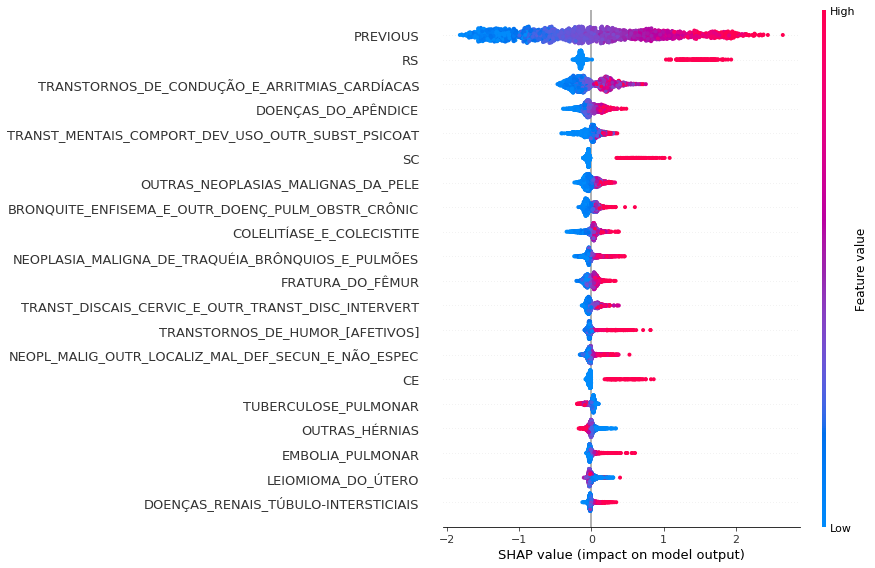

In [13]:
explainer = shap.TreeExplainer(regressor)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

### SHAP Individual Analysis

In [14]:
print(test_df.loc[test_df['MUNCOD'] == 355030]["RATE"])

data_for_prediction = test_df.loc[test_df['MUNCOD'] == 355030].drop(columns=["MUNCOD", "RATE"])
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(data_for_prediction)

3685    1.741006
Name: RATE, dtype: float64


In [15]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

## AdaBoost

In [16]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        learning_rate = params[1]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = AdaBoostRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (30,200), #n_estimators
        (0.01, 1) #learning_rate
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = AdaBoostRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1])
    regressor.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = regressor.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    print("\n")
    count += 1
print("=============== SUMMARY AdaBoost ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["AdaBoost"] = scores
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
print(final_feat_df.head(20))
end = time.time()

print("\nTotal run time:", end-start)

print("\n=============== SAVE Y_TEST_PRED ===============")
y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred})
y_test_pred.to_csv('y_test_pred_AdaBoost.csv')

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (2841, 5)
Previsão de 1s: (4871, 5)
Real 0s: (4263, 5)
Real 1s: (3449, 5)
Acc 0.6610477178423236
recall_score 0.8271962887793564
precision_score 0.5857113529049477
f1_score 0.6858173076923078

Metrics Test:
Previsão de 0s: (718, 5)
Previsão de 1s: (1210, 5)
Real 0s: (1088, 5)
Real 1s: (840, 5)
Acc 0.6327800829875518
recall_score 0.7988095238095239
precision_score 0.5545454545454546
f1_score 0.6546341463414636

RMSE Train: 3.671963956484087
RMSE Test: 3.7650085157458753
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.8271962887793564
Up/Down Recall Test: 0.7988095238095239
# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3011, 5)
Previsão de 1s: (4701, 5)
Real 0s: (4307, 5)
Real 1s: (3405, 5)
Acc 0.6613070539419087
recall_score 0.8067547723935389
precision_score 0.5843437566475218
f1_score 0.6777695534172218

Metrics Test:
Previsão de 0s: (735, 5)
Previsão de 1s: (1193, 5)
Real 0s: (1044, 5)
Real 1s: (884, 5)
Acc 0.6592323651452282
recall_score 0.8031674208144797
precision_score 0.595138306789606
f1_score 0.6836783822821377

RMSE Train: 3.6928384462698403
RMSE Test: 3.655694655967712
RMSE Baseline Train: 4.9829751515185725
RMSE Baseline Test: 4.792725690796757
Up/Down Recall Train: 0.8067547723935389
Up/Down Recall Test: 0.8031674208144797
# Get Feature Importance


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (2876, 5)
Previsão de 1s: (4836, 5)
Real 0s: (4295, 5)
Real 1s: (3417, 5)
Acc 0.6489885892116183
recall_score 0.8115305823822067
precision_score 0.5734077750206783
f1_score 0.6719980613110385

Metrics Test:
Previsão de 0s: (730, 5)
Previsão de 1s: (1198, 5)
Real 0s: (1056, 5)
Real 1s: (872, 5)
Acc 0.6587136929460581
recall_score 0.8096330275229358
precision_score 0.5893155258764607
f1_score 0.6821256038647343

RMSE Train: 3.6977330067724585
RMSE Test: 3.781543403229012
RMSE Baseline Train: 4.926016728480818
RMSE Baseline Test: 5.022730507675877
Up/Down Recall Train: 0.8115305823822067
Up/Down Recall Test: 0.8096330275229358
# Get Feature Importance


=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (2748, 5)
Previsão de 1s: (4964, 5)
Real 0s: (4272, 5)
Real 1s: (3440, 5)
Acc 0.6556016597510373
recall_score 0.8354651162790697
precision_score 0.5789685737308622
f1_score 0.6839600190385531

Metrics Test:
Previsão de 0s: (676, 5)
Previsão de 1s: (1252, 5)
Real 0s: (1079, 5)
Real 1s: (849, 5)
Acc 0.6426348547717843
recall_score 0.8315665488810365
precision_score 0.5638977635782748
f1_score 0.6720609233698239

RMSE Train: 3.6701099297686564
RMSE Test: 3.798693615801489
RMSE Baseline Train: 4.930784973910473
RMSE Baseline Test: 5.003980730784661
Up/Down Recall Train: 0.8354651162790697
Up/Down Recall Test: 0.8315665488810365
# Get Feature Importance


=============== RUN 5 ===============
# Feature Selection: correlation
125 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (2522, 5)
Previsão de 1s: (5190, 5)
Real 0s: (4267, 5)
Real 1s: (3445, 5)
Acc 0.6443205394190872
recall_score 0.8551523947750362
precision_score 0.5676300578034682
f1_score 0.6823393167342212

Metrics Test:
Previsão de 0s: (646, 5)
Previsão de 1s: (1282, 5)
Real 0s: (1084, 5)
Real 1s: (844, 5)
Acc 0.6390041493775933
recall_score 0.8471563981042654
precision_score 0.5577223088923557
f1_score 0.6726246472248354

RMSE Train: 3.6950451976643
RMSE Test: 3.72106436668285
RMSE Baseline Train: 4.919021930072528
RMSE Baseline Test: 5.050077028688922
Up/Down Recall Train: 0.8551523947750362
Up/Down Recall Test: 0.8471563981042654
# Get Feature Importance


=============== SUMMARY AdaBoost ===============
# Average Metrics
rmse_train             3.685538
rmse_test              3.744401
rmse_baseline_train    4.945446
rmse_baseline_test     4.944454
up_down_train          0.827220
up_down_test           

In [32]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

with open('selected_cor_features', 'rb') as f:
    selected_cor_features = pickle.load(f)
    
X_train = X_train[selected_cor_features]

def train_model(params):
    n_estimators = params[0]
    learning_rate = params[1]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = AdaBoostRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (30,200), #n_estimators
    (0.01, 1) #learning_rate
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = AdaBoostRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1])
regressor.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/adaboost_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


## Gradient Boosting

In [18]:
from sklearn.model_selection import KFold
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        learning_rate = params[1]
        max_depth = params[2]
        min_samples_splits = params[3]
        min_samples_leafs = params[4]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = GradientBoostingRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate,
                                          max_depth=max_depth,min_samples_split=min_samples_splits,min_samples_leaf=min_samples_leafs)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (30,200),  #n_estimators
        (0.01, 1), #learning_rate
        (1,32),    #max_depth
        (0.1, 1),  #min_samples_splits 
        (0.1, 0.5) #min_samples_leafs 
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = GradientBoostingRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1],
                                         max_depth=resultado_gp.x[2], min_samples_split=resultado_gp.x[3], min_samples_leaf=resultado_gp.x[4])
    regressor.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = regressor.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    print("\n")
    count += 1
print("=============== SUMMARY Gradient Boosting ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["Gradient Boosting"] = scores
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
print(final_feat_df.head(20))
end = time.time()

print("\nTotal run time:", end-start)

print("\n=============== SAVE Y_TEST_PRED ===============")
y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred})
y_test_pred.to_csv('y_test_pred_GradientBoosting.csv')

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3120, 5)
Previsão de 1s: (4592, 5)
Real 0s: (4263, 5)
Real 1s: (3449, 5)
Acc 0.6832209543568465
recall_score 0.8115395766888953
precision_score 0.6095383275261324
f1_score 0.696182066907101

Metrics Test:
Previsão de 0s: (818, 5)
Previsão de 1s: (1110, 5)
Real 0s: (1088, 5)
Real 1s: (840, 5)
Acc 0.6576763485477178
recall_score 0.7678571428571429
precision_score 0.581081081081081
f1_score 0.6615384615384615

RMSE Train: 3.57572807138647
RMSE Test: 3.7139470472056257
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.8115395766888953
Up/Down Recall Test: 0.7678571428571429
# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian 

In [33]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

with open('selected_cor_features', 'rb') as f:
    selected_cor_features = pickle.load(f)
    
X_train = X_train[selected_cor_features]

def train_model(params):
    n_estimators = params[0]
    learning_rate = params[1]
    max_depth = params[2]
    min_samples_splits = params[3]
    min_samples_leafs = params[4]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = GradientBoostingRegressor(random_state=42,n_estimators=n_estimators, learning_rate=learning_rate,
                                      max_depth=max_depth,min_samples_split=min_samples_splits,min_samples_leaf=min_samples_leafs)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (30,200), #n_estimators
    (0.01, 1), #learning_rate
    (1,32), #max_depth
    (0.1, 1), #min_samples_splits 
    (0.1, 0.5) #min_samples_leafs 
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = GradientBoostingRegressor(random_state=42,n_estimators=resultado_gp.x[0], learning_rate=resultado_gp.x[1],
                                     max_depth=resultado_gp.x[2], min_samples_split=resultado_gp.x[3], min_samples_leaf=resultado_gp.x[4])
regressor.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/gradient_boost_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

## SVR

### MinMax

In [20]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
count = 1

for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    mm_x = MinMaxScaler()
    mm_y = MinMaxScaler()
    mm_x.fit(X_train)
#     yy
    y_reshape = y_train.values.reshape(-1, 1)
    y_df = y_train.to_frame()
    mm_y.fit(y_reshape)
    X_train_transf = pd.DataFrame(mm_x.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_transf = pd.DataFrame(mm_x.transform(X_test), index=X_test.index, columns=X_test.columns)
    y_train_transf = pd.DataFrame(mm_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)
    
    print("# Bayesian Optimization")
    def train_model(params):
        gamma = params[0]
        C = params[1]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train_transf,y_train_transf.values.ravel(),test_size=0.33,random_state=42)

        model = SVR(gamma=gamma, C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (0.001,0.9), #gamma
        (1,10000),   #C
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = SVR(gamma=resultado_gp.x[0], C=resultado_gp.x[1])
    regressor.fit(X_train_transf, y_train_transf.values.ravel())
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test_transf) 
    y_pred_train = regressor.predict(X_train_transf)
    y_pred_train_reshaped = mm_y.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_reshaped = mm_y.inverse_transform(y_pred.reshape(-1,1))
    y_train_reshaped = mm_y.inverse_transform(y_train_transf.values)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train_reshaped.ravel(), y_test, y_pred_reshaped.ravel(), y_pred_train_reshaped.ravel(), scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY SVR MM ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["SVR MM"] = scores

end = time.time()

print("\nTotal run time:", end-start)

print("\n=============== SAVE Y_TEST_PRED ===============")
y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred_reshaped.ravel()})
y_test_pred.to_csv('y_test_pred_MinMax.csv')

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3500, 5)
Previsão de 1s: (4212, 5)
Real 0s: (4263, 5)
Real 1s: (3449, 5)
Acc 0.6933350622406639
recall_score 0.7677587706581618
precision_score 0.6286799620132953
f1_score 0.6912935648087717

Metrics Test:
Previsão de 0s: (879, 5)
Previsão de 1s: (1049, 5)
Real 0s: (1088, 5)
Real 1s: (840, 5)
Acc 0.6779045643153527
recall_score 0.7547619047619047
precision_score 0.6043851286939943
f1_score 0.6712546320804659

RMSE Train: 3.570956281596126
RMSE Test: 3.67115321596018
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.7677587706581618
Up/Down Recall Test: 0.7547619047619047


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3562, 5)
Previsão de 1s: (4150, 5)
Real 0s: (4307, 5)
Real 1s: (3405, 5)
Acc 0.6868516597510373
recall_score 0.7547723935389133
precision_score 0.619277108433735
f1_score 0.6803441429516877

Metrics Test:
Previsão de 0s: (872, 5)
Previsão de 1s: (1056, 5)
Real 0s: (1044, 5)
Real 1s: (884, 5)
Acc 0.6991701244813278
recall_score 0.7692307692307693
precision_score 0.6439393939393939
f1_score 0.7010309278350515

RMSE Train: 3.60079434356746
RMSE Test: 3.5696441953250675
RMSE Baseline Train: 4.9829751515185725
RMSE Baseline Test: 4.792725690796757
Up/Down Recall Train: 0.7547723935389133
Up/Down Recall Test: 0.7692307692307693


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3559, 5)
Previsão de 1s: (4153, 5)
Real 0s: (4295, 5)
Real 1s: (3417, 5)
Acc 0.6877593360995851
recall_score 0.755340942347088
precision_score 0.6214784493137491
f1_score 0.6819022457067371

Metrics Test:
Previsão de 0s: (903, 5)
Previsão de 1s: (1025, 5)
Real 0s: (1056, 5)
Real 1s: (872, 5)
Acc 0.6955394190871369
recall_score 0.7511467889908257
precision_score 0.6390243902439025
f1_score 0.6905640484976279

RMSE Train: 3.5765630273755167
RMSE Test: 3.6815820358679185
RMSE Baseline Train: 4.926016728480818
RMSE Baseline Test: 5.022730507675877
Up/Down Recall Train: 0.755340942347088
Up/Down Recall Test: 0.7511467889908257


=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3553, 5)
Previsão de 1s: (4159, 5)
Real 0s: (4272, 5)
Real 1s: (3440, 5)
Acc 0.6907417012448133
recall_score 0.7578488372093023
precision_score 0.626833373407069
f1_score 0.6861429135412555

Metrics Test:
Previsão de 0s: (897, 5)
Previsão de 1s: (1031, 5)
Real 0s: (1079, 5)
Real 1s: (849, 5)
Acc 0.6815352697095436
recall_score 0.7455830388692579
precision_score 0.6139670223084384
f1_score 0.6734042553191488

RMSE Train: 3.5573387317410234
RMSE Test: 3.72820811105112
RMSE Baseline Train: 4.930784973910473
RMSE Baseline Test: 5.003980730784661
Up/Down Recall Train: 0.7578488372093023
Up/Down Recall Test: 0.7455830388692579


=============== RUN 5 ===============
# Feature Selection: correlation
125 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3501, 5)
Previsão de 1s: (4211, 5)
Real 0s: (4267, 5)
Real 1s: (3445, 5)
Acc 0.7053941908713693
recall_score 0.781422351233672
precision_score 0.6392780812158633
f1_score 0.703239289446186

Metrics Test:
Previsão de 0s: (882, 5)
Previsão de 1s: (1046, 5)
Real 0s: (1084, 5)
Real 1s: (844, 5)
Acc 0.6908713692946058
recall_score 0.7665876777251185
precision_score 0.6185468451242829
f1_score 0.6846560846560846

RMSE Train: 3.396568207450847
RMSE Test: 3.550331521595921
RMSE Baseline Train: 4.919021930072528
RMSE Baseline Test: 5.050077028688922
Up/Down Recall Train: 0.781422351233672
Up/Down Recall Test: 0.7665876777251185


=============== SUMMARY SVR MM ===============
# Average Metrics
rmse_train             3.540444
rmse_test              3.640184
rmse_baseline_train    4.945446
rmse_baseline_test     4.944454
up_down_train          0.763429
up_down_test           0.757462
dtype: float64

To

In [10]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

with open('selected_cor_features', 'rb') as f:
    selected_cor_features = pickle.load(f)
    
X_train = X_train[selected_cor_features]

mm_x = MinMaxScaler()
mm_y = MinMaxScaler()
mm_x.fit(X_train)
# yy
y_reshape = y_train.values.reshape(-1, 1)
y_df = y_train.to_frame()
mm_y.fit(y_reshape)

joblib.dump(mm_x, "mm_x.save")
joblib.dump(mm_y, "mm_y.save")

X_train = pd.DataFrame(mm_x.transform(X_train), index=X_train.index, columns=X_train.columns)
y_train = pd.DataFrame(mm_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)

def train_model(params):
    gamma = params[0]
    C = params[1]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train.values.ravel(),test_size=0.33,random_state=42)

    model = SVR(gamma=gamma, C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (0.001,0.9), #gamma
    (1,10000), #C
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = SVR(gamma=resultado_gp.x[0], C=resultado_gp.x[1])
regressor.fit(X_train,y_train.values.ravel())

filename = root + 'Dashboard/Models/sav/svr_mm_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

### StandardScaler

In [22]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
count = 1

for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    sc_x = StandardScaler()
    sc_y = StandardScaler()
    sc_x.fit(X_train)
    y_reshape = y_train.values.reshape(-1, 1)
    y_df = y_train.to_frame()
    sc_y.fit(y_reshape)
    X_train_transf = pd.DataFrame(sc_x.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_transf = pd.DataFrame(sc_x.transform(X_test), index=X_test.index, columns=X_test.columns)
    y_train_transf = pd.DataFrame(sc_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)
    
    print("# Bayesian Optimization")
    def train_model(params):
        gamma = params[0]
        C = params[1]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train_transf.values.ravel(),test_size=0.33,random_state=42)

        model = SVR(gamma=gamma, C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (0.001,0.9), #gamma
        (1,10000),   #C
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = SVR(gamma=resultado_gp.x[0], C=resultado_gp.x[1])
    regressor.fit(X_train_transf, y_train_transf.values.ravel())
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test_transf) 
    y_pred_train = regressor.predict(X_train_transf)
    y_pred_train_reshaped = sc_y.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_reshaped = sc_y.inverse_transform(y_pred.reshape(-1,1))
    y_train_reshaped = sc_y.inverse_transform(y_train_transf)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train_reshaped.ravel(), y_test, y_pred_reshaped.ravel(), y_pred_train_reshaped.ravel(), scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY SVR SC ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["SVR SC"] = scores

end = time.time()

print("\nTotal run time:", end-start)

print("\n=============== SAVE Y_TEST_PRED ===============")
y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred_reshaped.ravel()})
y_test_pred.to_csv('y_test_pred_StandardScaler.csv')

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3714, 5)
Previsão de 1s: (3998, 5)
Real 0s: (4263, 5)
Real 1s: (3449, 5)
Acc 0.9010632780082988
recall_score 0.9689765149318643
precision_score 0.8359179589794897
f1_score 0.8975426346179669

Metrics Test:
Previsão de 0s: (945, 5)
Previsão de 1s: (983, 5)
Real 0s: (1088, 5)
Real 1s: (840, 5)
Acc 0.5980290456431535
recall_score 0.6238095238095238
precision_score 0.5330620549338759
f1_score 0.5748765770707626

RMSE Train: 0.4233561826587949
RMSE Test: 6.959961254568365
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.9689765149318643
Up/Down Recall Test: 0.6238095238095238


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3755, 5)
Previsão de 1s: (3957, 5)
Real 0s: (4307, 5)
Real 1s: (3405, 5)
Acc 0.9024896265560166
recall_score 0.9706314243759178
precision_score 0.8352287086176396
f1_score 0.897853844064113

Metrics Test:
Previsão de 0s: (916, 5)
Previsão de 1s: (1012, 5)
Real 0s: (1044, 5)
Real 1s: (884, 5)
Acc 0.6182572614107884
recall_score 0.6561085972850679
precision_score 0.5731225296442688
f1_score 0.6118143459915611

RMSE Train: 0.42398263070299586
RMSE Test: 6.871955890744239
RMSE Baseline Train: 4.9829751515185725
RMSE Baseline Test: 4.792725690796757
Up/Down Recall Train: 0.9706314243759178
Up/Down Recall Test: 0.6561085972850679


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3732, 5)
Previsão de 1s: (3980, 5)
Real 0s: (4295, 5)
Real 1s: (3417, 5)
Acc 0.8989885892116183
recall_score 0.9683933274802459
precision_score 0.8314070351758794
f1_score 0.8946870352845748

Metrics Test:
Previsão de 0s: (961, 5)
Previsão de 1s: (967, 5)
Real 0s: (1056, 5)
Real 1s: (872, 5)
Acc 0.6218879668049793
recall_score 0.6364678899082569
precision_score 0.5739400206825233
f1_score 0.6035889070146819

RMSE Train: 0.41357530101938705
RMSE Test: 6.540292940104579
RMSE Baseline Train: 4.926016728480818
RMSE Baseline Test: 5.022730507675877
Up/Down Recall Train: 0.9683933274802459
Up/Down Recall Test: 0.6364678899082569


=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3740, 5)
Previsão de 1s: (3972, 5)
Real 0s: (4272, 5)
Real 1s: (3440, 5)
Acc 0.9037863070539419
recall_score 0.9694767441860465
precision_score 0.8396273917421954
f1_score 0.8998920669185105

Metrics Test:
Previsão de 0s: (935, 5)
Previsão de 1s: (993, 5)
Real 0s: (1079, 5)
Real 1s: (849, 5)
Acc 0.5923236514522822
recall_score 0.6219081272084805
precision_score 0.5317220543806647
f1_score 0.5732899022801302

RMSE Train: 0.4224250775019132
RMSE Test: 6.609451124098031
RMSE Baseline Train: 4.930784973910473
RMSE Baseline Test: 5.003980730784661
Up/Down Recall Train: 0.9694767441860465
Up/Down Recall Test: 0.6219081272084805


=============== RUN 5 ===============
# Feature Selection: correlation
125 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3689, 5)
Previsão de 1s: (4023, 5)
Real 0s: (4267, 5)
Real 1s: (3445, 5)
Acc 0.8983402489626556
recall_score 0.9701015965166908
precision_score 0.8307233407904548
f1_score 0.8950187466523835

Metrics Test:
Previsão de 0s: (924, 5)
Previsão de 1s: (1004, 5)
Real 0s: (1084, 5)
Real 1s: (844, 5)
Acc 0.6016597510373444
recall_score 0.6398104265402843
precision_score 0.5378486055776892
f1_score 0.5844155844155844

RMSE Train: 0.42431846058430306
RMSE Test: 6.672748133090723
RMSE Baseline Train: 4.919021930072528
RMSE Baseline Test: 5.050077028688922
Up/Down Recall Train: 0.9701015965166908
Up/Down Recall Test: 0.6398104265402843


=============== SUMMARY SVR SC ===============
# Average Metrics
rmse_train             0.421532
rmse_test              6.730882
rmse_baseline_train    4.945446
rmse_baseline_test     4.944454
up_down_train          0.969516
up_down_test           0.635621
dtype: float6

In [11]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

with open('selected_cor_features', 'rb') as f:
    selected_cor_features = pickle.load(f)
    
X_train = X_train[selected_cor_features]

sc_x = StandardScaler()
sc_y = StandardScaler()
sc_x.fit(X_train)
# yy
y_reshape = y_train.values.reshape(-1, 1)
y_df = y_train.to_frame()
sc_y.fit(y_reshape)

joblib.dump(sc_x, "sc_x.save")
joblib.dump(sc_y, "sc_y.save")

X_train = pd.DataFrame(sc_x.transform(X_train), index=X_train.index, columns=X_train.columns)
y_train = pd.DataFrame(sc_y.transform(y_reshape), index=y_df.index, columns=y_df.columns)

def train_model(params):
    gamma = params[0]
    C = params[1]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train.values.ravel(),test_size=0.33,random_state=42)

    model = SVR(gamma=gamma, C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (0.001,0.9), #gamma
    (1,10000), #C
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = SVR(gamma=resultado_gp.x[0], C=resultado_gp.x[1])
regressor.fit(X_train,y_train.values.ravel())

filename = root + 'Dashboard/Models/sav/svr_sc_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

The objective has been evaluated at this point before.


## LinearRegression

### LinearRegression

In [30]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
count = 1

for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    print("# Fitting the model")
    regressor = LinearRegression()
    regressor.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY LinearRegression ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["LinearRegression"] = scores

end = time.time()

print("\nTotal run time:", end-start)

print("\n=============== SAVE Y_TEST_PRED ===============")
y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred})
y_test_pred.to_csv('y_test_pred_LinearRegression.csv')

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3314, 5)
Previsão de 1s: (4398, 5)
Real 0s: (4263, 5)
Real 1s: (3449, 5)
Acc 0.6886670124481328
recall_score 0.7895042041171354
precision_score 0.6191450659390633
f1_score 0.6940231935771632

Metrics Test:
Previsão de 0s: (837, 5)
Previsão de 1s: (1091, 5)
Real 0s: (1088, 5)
Real 1s: (840, 5)
Acc 0.6696058091286307
recall_score 0.7702380952380953
precision_score 0.5930339138405133
f1_score 0.6701191092698084

RMSE Train: 3.555626478272322
RMSE Test: 3.7028201907691285
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.7895042041171354
Up/Down Recall Test: 0.7702380952380953


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Fitting the model
# Making predictions
# Calculating me

# SHAP analysis


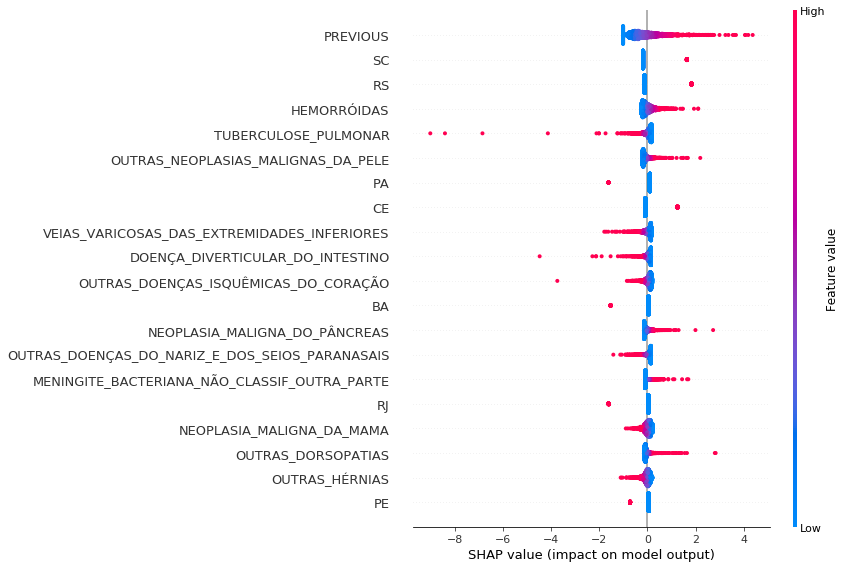

In [32]:
print("# SHAP analysis")
explainer = shap.LinearExplainer(regressor, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [33]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

with open('selected_cor_features', 'rb') as f:
    selected_cor_features = pickle.load(f)
    
X_train = X_train[selected_cor_features]

regressor = LinearRegression()
regressor.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/linear_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

### ElasticNet

In [21]:
start = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"rmse_train": [], "rmse_test": [], "rmse_baseline_train": [], "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})
count = 1

for train_index, test_index in kf.split(X):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: correlation")
    selected_cor_features = cor_feature_selector(X_train,y_train,corr_min_value)
    X_train = X_train[selected_cor_features]
    X_test = X_test[selected_cor_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        alpha = params[0]
        l1_ratio = params[1]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = ElasticNet(random_state=42, alpha=alpha, l1_ratio=l1_ratio, tol=0.5)

        model.fit(xf_train_params, yf_train_params)
        yf_pred = model.predict(xf_val)

        return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
    space = [
        (0.01,100), #alpha
        (0,1), #l1_ratio
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    print("# Fitting the model")
    regressor = ElasticNet(random_state=42, alpha=resultado_gp.x[0], l1_ratio=resultado_gp.x[1], tol=0.5)
    regressor.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY LinearRegression ElasticNet ===============")
print("# Average Metrics")
print(scores.mean())
all_models_scores["LinearRegression ElasticNet"] = scores

end = time.time()

print("\nTotal run time:", end-start)

print("\n=============== SAVE Y_TEST_PRED ===============")
y_test_pred = pd.DataFrame({"previous": X_test["PREVIOUS"],"y_test": y_test, "y_pred": y_pred})
y_test_pred.to_csv('y_test_pred_ElasticNet.csv')

=============== RUN 1 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3327, 5)
Previsão de 1s: (4385, 5)
Real 0s: (4263, 5)
Real 1s: (3449, 5)
Acc 0.6849066390041494
recall_score 0.7834154827486228
precision_score 0.6161915621436717
f1_score 0.689813632882308

Metrics Test:
Previsão de 0s: (830, 5)
Previsão de 1s: (1098, 5)
Real 0s: (1088, 5)
Real 1s: (840, 5)
Acc 0.6639004149377593
recall_score 0.7678571428571429
precision_score 0.587431693989071
f1_score 0.6656346749226006

RMSE Train: 3.60098024512164
RMSE Test: 3.7371500218581337
RMSE Baseline Train: 4.968428887729926
RMSE Baseline Test: 4.852756179751097
Up/Down Recall Train: 0.7834154827486228
Up/Down Recall Test: 0.7678571428571429


=============== RUN 2 ===============
# Feature Selection: correlation
124 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3358, 5)
Previsão de 1s: (4354, 5)
Real 0s: (4307, 5)
Real 1s: (3405, 5)
Acc 0.6827022821576764
recall_score 0.7800293685756241
precision_score 0.6100137804317869
f1_score 0.6846243072560897

Metrics Test:
Previsão de 0s: (802, 5)
Previsão de 1s: (1126, 5)
Real 0s: (1044, 5)
Real 1s: (884, 5)
Acc 0.6825726141078838
recall_score 0.7907239819004525
precision_score 0.6207815275310835
f1_score 0.6955223880597015

RMSE Train: 3.6363475205053093
RMSE Test: 3.6265553712534917
RMSE Baseline Train: 4.9829751515185725
RMSE Baseline Test: 4.792725690796757
Up/Down Recall Train: 0.7800293685756241
Up/Down Recall Test: 0.7907239819004525


=============== RUN 3 ===============
# Feature Selection: correlation
127 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3372, 5)
Previsão de 1s: (4340, 5)
Real 0s: (4295, 5)
Real 1s: (3417, 5)
Acc 0.6824429460580913
recall_score 0.7767047117354404
precision_score 0.6115207373271889
f1_score 0.6842851617893515

Metrics Test:
Previsão de 0s: (867, 5)
Previsão de 1s: (1061, 5)
Real 0s: (1056, 5)
Real 1s: (872, 5)
Acc 0.6893153526970954
recall_score 0.7649082568807339
precision_score 0.6286522148916117
f1_score 0.6901189860320746

RMSE Train: 3.6106343478527756
RMSE Test: 3.677262629397819
RMSE Baseline Train: 4.926016728480818
RMSE Baseline Test: 5.022730507675877
Up/Down Recall Train: 0.7767047117354404
Up/Down Recall Test: 0.7649082568807339


=============== RUN 4 ===============
# Feature Selection: correlation
119 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3314, 5)
Previsão de 1s: (4398, 5)
Real 0s: (4272, 5)
Real 1s: (3440, 5)
Acc 0.683091286307054
recall_score 0.7840116279069768
precision_score 0.6132332878581174
f1_score 0.6881857616738964

Metrics Test:
Previsão de 0s: (843, 5)
Previsão de 1s: (1085, 5)
Real 0s: (1079, 5)
Real 1s: (849, 5)
Acc 0.6742738589211619
recall_score 0.7691401648998822
precision_score 0.6018433179723502
f1_score 0.6752843846949328

RMSE Train: 3.5912813232145444
RMSE Test: 3.7704255272009775
RMSE Baseline Train: 4.930784973910473
RMSE Baseline Test: 5.003980730784661
Up/Down Recall Train: 0.7840116279069768
Up/Down Recall Test: 0.7691401648998822


=============== RUN 5 ===============
# Feature Selection: correlation
125 selected features (correlation)
# Bayesian Optimization


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics

Metrics Train:
Previsão de 0s: (3294, 5)
Previsão de 1s: (4418, 5)
Real 0s: (4267, 5)
Real 1s: (3445, 5)
Acc 0.6832209543568465
recall_score 0.7866473149492017
precision_score 0.6133997283838841
f1_score 0.6893043367671372

Metrics Test:
Previsão de 0s: (821, 5)
Previsão de 1s: (1107, 5)
Real 0s: (1084, 5)
Real 1s: (844, 5)
Acc 0.6768672199170125
recall_score 0.7867298578199052
precision_score 0.5998193315266486
f1_score 0.6806765761148129

RMSE Train: 3.6240456971412325
RMSE Test: 3.640469132702445
RMSE Baseline Train: 4.919021930072528
RMSE Baseline Test: 5.050077028688922
Up/Down Recall Train: 0.7866473149492017
Up/Down Recall Test: 0.7867298578199052


=============== SUMMARY LinearRegression ElasticNet ===============
# Average Metrics
rmse_train             3.612658
rmse_test              3.690373
rmse_baseline_train    4.945446
rmse_baseline_test     4.944454
up_down_train          0.782162
up_down_test           0.

# SHAP analysis


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


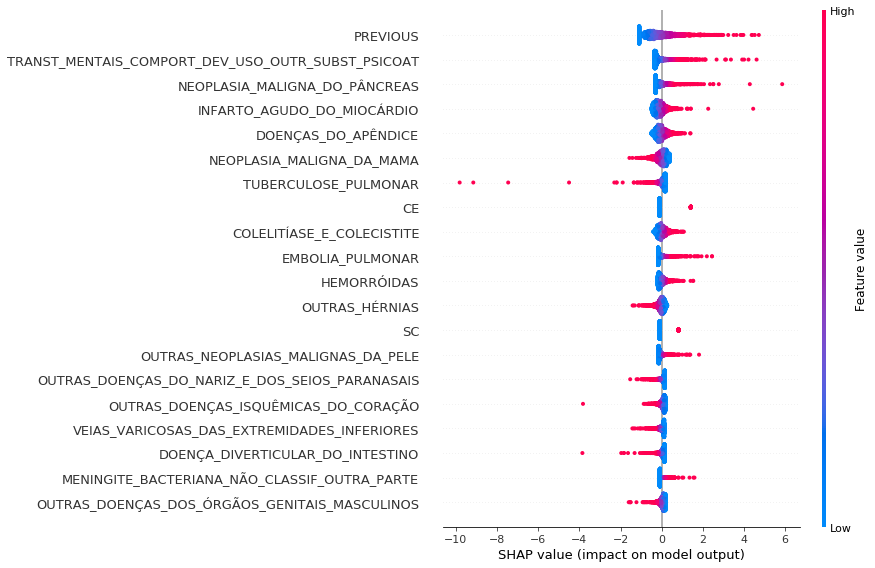

In [26]:
print("# SHAP analysis")
explainer = shap.LinearExplainer(regressor, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [27]:
X_train = train_df.drop(columns=["RATE"])
y_train = train_df["RATE"]

with open('selected_cor_features', 'rb') as f:
    selected_cor_features = pickle.load(f)
    
X_train = X_train[selected_cor_features]

def train_model(params):
    alpha = params[0]
    l1_ratio = params[1]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = ElasticNet(random_state=42, alpha=alpha, l1_ratio=l1_ratio, tol=0.5)

    model.fit(xf_train_params, yf_train_params)
    yf_pred = model.predict(xf_val)

    return np.sqrt(metrics.mean_squared_error(yf_val, yf_pred))
space = [
    (0.01,100), #alpha
    (0,1), #l1_ratio
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

regressor = ElasticNet(random_state=42, alpha=resultado_gp.x[0], l1_ratio=resultado_gp.x[1], tol=0.5)
regressor.fit(X_train,y_train)

filename = root + 'Dashboard/Models/sav/elastic_net_regression.sav'
pickle.dump(regressor, open(filename, 'wb'))

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# All Models

Getting a summary of all model results

In [25]:
df_result = pd.DataFrame({"Model": [], 'rmse_train': [], 'rmse_test':[], "rmse_baseline_train": [],
                          "rmse_baseline_test": [], "up_down_train": [], "up_down_test": []})

for model,scores in all_models_scores.items():
    df_result = df_result.append({"Model": model,
                                 "rmse_train": scores["rmse_train"].mean(),
                                 "rmse_test": scores["rmse_test"].mean(),
                                 "rmse_baseline_train": scores["rmse_baseline_train"].mean(),
                                 "rmse_baseline_test": scores["rmse_baseline_test"].mean(),
                                 "up_down_train": scores["up_down_train"].mean(),
                                 "up_down_test": scores["up_down_test"].mean()},ignore_index=True)
df_result

,Model,rmse_train,rmse_test,rmse_baseline_train,rmse_baseline_test,up_down_train,up_down_test
0,Random Forest,1.733216,3.607341,4.945446,4.944454,0.950687,0.805540
1,AdaBoost,3.685538,3.744401,4.945446,4.944454,0.827220,0.818067
2,Gradient Boosting,3.487861,3.665701,4.945446,4.944454,0.807104,0.782823
3,SVR MM,3.540444,3.640184,4.945446,4.944454,0.763429,0.757462
4,SVR SC,0.421532,6.730882,4.945446,4.944454,0.969516,0.635621
